<a href="https://colab.research.google.com/github/mikhail-mat/mit-ocw_hands-on-deep-learning/blob/main/CNN_Classifying_Emotions_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 15.777 Homework 1 (Spring 2024): Convolutional Neural Networks


In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

# initialize the seeds of different random number generators so that the
# results will be the same every time the notebook is run
keras.utils.set_random_seed(42)

# Introduction

Your goal in this exercise is to detect emotion from a facial image. To that end, we will use the 2013 Facial Expression Recognition (FER) dataset.

The dataset consists of ~36,000 images, each annotated with one of seven labels:
* angry
* disgust
* fear
* happy
* sad
* surprise
* neutral

The goal of this homework assignment is to walk you through how to:

1. Build a Convolutional Neural Network (CNN) *from scratch* to detect emotion in facial images (Problems 1 and 2)
2. Use data augmentation to increase the size of your training data (Problem 3)
3. Use transfer learning to customize a pretrained model to solve the same problem (Problem 4)

But first, let's get the data.

In [4]:
!wget -q -O fer2013.csv -P ./ https://dl.dropbox.com/scl/fi/e2ik6aryemboameq1rwwn/fer2013.csv?rlkey=ux7tyge6flk9nnuul9desizgf&dl=0

The data has 35887 rows and 3 columns:
* Emotion - encoded as the numbers 0 (anger) through 6 (neutral)
* Pixels - A space-separated list of numbers representing the pixels of this image.
* Usage - No need to worry about this column

In [5]:
data = pd.read_csv('fer2013.csv')
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


The pixel values for each image is provided as a space-separated list of numbers. How many pixels in an image?

In [6]:
len(data.loc[0, 'pixels'].split(' '))

2304

### Pre-Processing the Pixels (Independent Variable)

Each image is encoded as a list of 2304 pixels. We will reshape this into an 48x48 image next.

Recall that a color image is represented as a tensor of dimension N by M by 3, where the 3 represents the 3 color channels (red, green and blue). Our images from the FER 2013 dataset are grayscale images, with only a single channel representing the amount of black in the image. This is inconvenient to work with because many pre-trained models used in transfer learning, such as the one we will use in Problem 4, require the input image to have 3 channels.

To get around this, we will take each image, a 48 x 48 tensor and transform it into a 48 x 48 x 3 tensor by simply duplicating it three times. We can think of a greyscale image is one where the red, green and blue color channels are exactly the same.

The following code transforms our dataset into a tensor of shape (35887, 48, 48, 3): a list of 35887 images, each of which are a (48, 48, 3)-shape tensor.

In [7]:
pixels = data['pixels'].tolist()
width, height = 48, 48
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')] # read each face as a 1-d array
    face = np.asarray(face).reshape(width, height) # reshape the length 2304 1-d array into an 48x48 array
    face = np.stack((face,)*3, axis=-1)
    faces.append(face.astype('float32'))

faces = np.asarray(faces)
faces.shape

(35887, 48, 48, 3)

For the first image, i.e. `faces[0]`, we can examine its first channel (corresponding to "red").

In [8]:
faces[0, :, :, 0]

array([[ 70.,  80.,  82., ...,  52.,  43.,  41.],
       [ 65.,  61.,  58., ...,  56.,  52.,  44.],
       [ 50.,  43.,  54., ...,  49.,  56.,  47.],
       ...,
       [ 91.,  65.,  42., ...,  72.,  56.,  43.],
       [ 77.,  82.,  79., ..., 105.,  70.,  46.],
       [ 77.,  72.,  84., ..., 106., 109.,  82.]], dtype=float32)

This is the exact same as the second channel (corresponding to "blue"). And similarly for green.

In [9]:
faces[0, :, :, 1]

array([[ 70.,  80.,  82., ...,  52.,  43.,  41.],
       [ 65.,  61.,  58., ...,  56.,  52.,  44.],
       [ 50.,  43.,  54., ...,  49.,  56.,  47.],
       ...,
       [ 91.,  65.,  42., ...,  72.,  56.,  43.],
       [ 77.,  82.,  79., ..., 105.,  70.,  46.],
       [ 77.,  72.,  84., ..., 106., 109.,  82.]], dtype=float32)

### Pre-Processing for Emotions (Dependent Variable)

Next, let's take a look at how emotion (the dependent variable) is encoded. We have that 0 = 'angry', 1 = 'disgust', ... 6 = 'neutral'.

In [10]:
data.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

We will convert emotion to a one-hot encoding using the `pd.get_dummies` function.

In [11]:
emotions = pd.get_dummies(data['emotion']).to_numpy() # each emotion is 'one-hot' encoded as a 7-dim vector
emotions_names = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
emotions.shape

(35887, 7)

### Example Images
Lets take a look at some of these fun images!

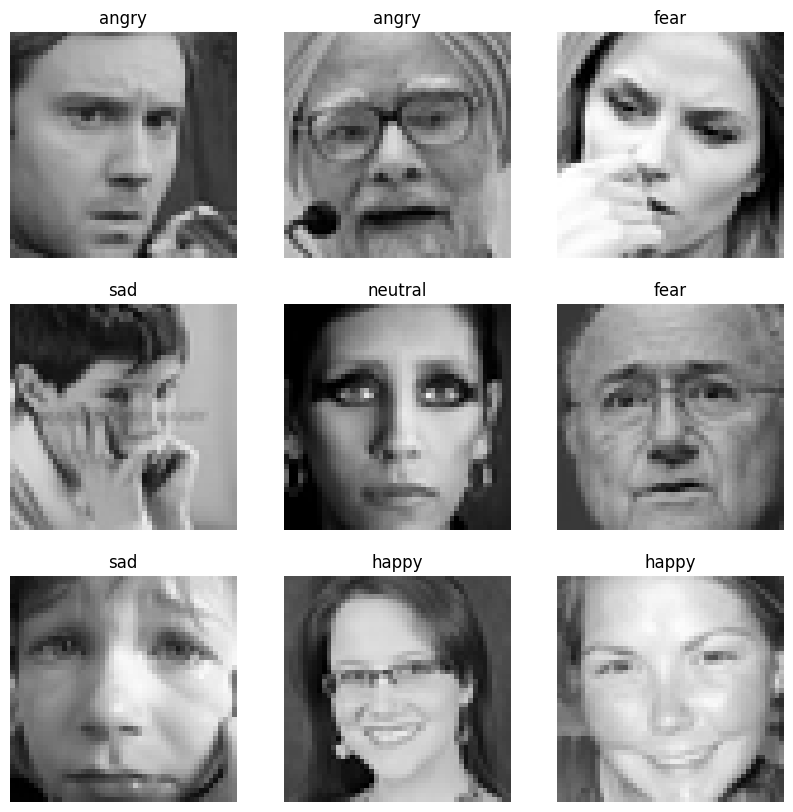

In [12]:
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.set_title(f"{emotions_names[np.argmax(emotions[i])]}")
    ax.imshow(faces[i].astype('uint8'))
    ax.axis('off')

### Train/Test Split
As in the original dataset, we will reserve the first 28,709 images for training and the rest for testing.

In [13]:
train_faces, train_emotions =  faces[:28709], emotions[:28709]
test_faces, test_emotions =  faces[28709:], emotions[28709:]

train_faces.shape, train_emotions.shape, test_faces.shape, test_emotions.shape

((28709, 48, 48, 3), (28709, 7), (7178, 48, 48, 3), (7178, 7))

# Problem 1: Base Model [30 Points]
In this problem, we will build a simple CNN with three convolutional blocks, one dense layer and one output layer.



## Part (a): Building the Model [10 points]
We would like to build a CNN with the following model summary. Fill in the code in the cell below so that the output of `model.summary()` matches that of the image above. Be sure to use relu activation for each of the Conv2D layers and the appropriate activation function for the output layer.


![](https://dl.dropbox.com/scl/fi/lrmaupoa243xrrsfj3qiy/cnn_model.PNG?rlkey=n5axqin6vx652qrgduyosg0pc&dl=0)

In [14]:
input = keras.Input(shape=(48, 48, 3), name="input")

###### YOUR CODE HERE #####

x = keras.layers.Rescaling(1)(input)

x = keras.layers.Conv2D(16, kernel_size=(2,2), activation='relu', name='Conv_1')(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(16, kernel_size=(2,2), activation='relu', name='Conv_2')(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(16, kernel_size=(2,2), activation='relu', name='Conv_3')(x)
x = keras.layers.MaxPool2D()(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)

output = keras.layers.Dense(7, activation='softmax')(x)

###### YOUR CODE HERE #####

model = keras.Model(input, output, name='CNN_model')
model.summary()

Model: "CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_1 (Conv2D)                 │ (None, 47, 47, 16)     │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (Conv2D)                 │ (None, 22, 22, 16)     │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_3 (Conv2D)                 │ (None, 10, 10, 16)     │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       102,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,743 (416.96 KB)

 Trainable params: 106,743 (416.96 KB)

 Non-trainable params: 0 (0.00 B)

## Part (b): Number of Parameters [10 points]
The model above has $106,743$ trainable parameters and is computed by $208 + 1040 + 1040 + 102656 + 1799$. Explain how each of these 5 numbers is calculated and show your computations (e.g. 208 = 16 * 3 * 4 + 16).


<font color='red'>**Your Answer.**</font>

The first convolutional layer Conv_1 uses 16 2x2 filters, there are 3 channels, so the number of weights is (16 * 3 * 4) + 16 biases = 208 parameters

The 2nd convolutional layer: 16 * 4 * 16 + 16 = 1040

The 3rd convolutional layer: 16 * 4 * 16 + 16 = 1040

The dense layer: 400 * 256 + 256 = 102656

The output layer: 256 * 7 + 7 = 1799

## Part (c): Training and Evaluation [10 points]

Let us compile our model and fit it on the training data. Since we one-hot-encoded the dependent variable, we use `categorical_crossentropy`, not `sparse_categorical_crossentropy`.

Fill in the parameters of `model.compile` and `model.fit` below.

* Compile the model using the `categorical_crossentropy` loss, `adam` optimizer and report the `accuracy` metric.
* Fit the model on `train_faces`, `train_emotions` using a batch size of 64, for 30 epochs and a validation split of 20%.

In [15]:
model.compile(
    ### YOUR CODE HERE ###
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_history = model.fit(
    ### YOUR CODE HERE ###
    train_faces,
    train_emotions,
    epochs=30,
    batch_size=64,
    validation_split=0.2
)

Epoch 1/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.2126 - loss: 5.1950 - val_accuracy: 0.2818 - val_loss: 1.7752
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2925 - loss: 1.7522 - val_accuracy: 0.3412 - val_loss: 1.6924
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3480 - loss: 1.6537 - val_accuracy: 0.3375 - val_loss: 1.6655
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3793 - loss: 1.5893 - val_accuracy: 0.3387 - val_loss: 1.6654
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4061 - loss: 1.5354 - val_accuracy: 0.3501 - val_loss: 1.6596
Epoch 6/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4313 - loss: 1.4815 - val_accuracy: 0.3490 - val_loss: 1.6936
Epoch 7/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4492 - loss: 1.4401 - val_accuracy: 0.3476 - val_loss: 1.7035
Epoch 8/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4706 - loss: 1.3917 - val_accuracy: 

**Epochs and Batches.**

In your own words, please explain the relationship between an epoch and a batch in stochastic gradient descent.

<font color='red'>**Your Answer.**</font>

An epoch is a pass through all of the training examples in gradient descent.

A batch is a subset of the whole training set that is used for one forward and backward pass through the neural network.

Gradient descent updates the weights once for each batch in one epoch based on the loss and the derivatives it calculates for that batch. The weights will be updated as many times in one epochs as there are batches.



When we ran `model.fit`, we saw that there are 359 batches per epoch. Please explain how this 359 is calculated. _Hint_: There are 28,709 training data points and 20% is set aside for validation.

<font color='red'>**Your Answer.**</font>

Images used for training: 28709 * 0.8 = 22967

Number of batches per epoch = 22967 / batch size

Number of batches per epoch = 22967 / 64

Number of batches per epoch = 359


**Plotting the Training/Validation Accuracy Curve**

Use the `plot_accuracy` function below to plot the training and validation accuracy across the training epochs.

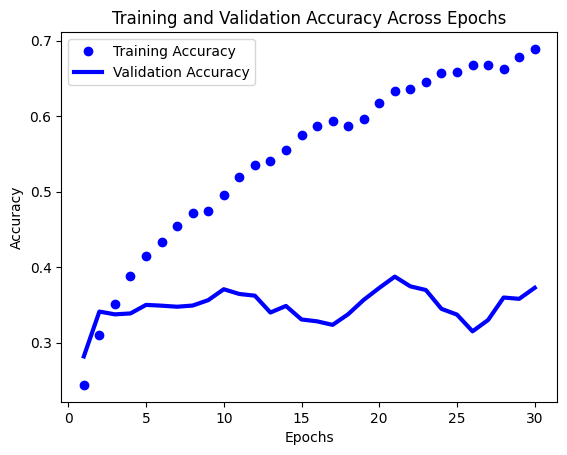

In [16]:
def plot_accuracy(model_history):
    history_dict = model_history.history
    acc = history_dict["accuracy"]
    val_acc = history_dict["val_accuracy"]
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, "bo", label="Training Accuracy", linewidth=3)
    plt.plot(epochs, val_acc, "b", label="Validation Accuracy", linewidth=3)
    plt.title("Training and Validation Accuracy Across Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_accuracy(model_history)

**Model Accuracy**

Calculate the accuracy on the test set. Write your code below to show the accuracy.

In [26]:
### YOUR CODE HERE ###
print(f'Test accuracy: {model.evaluate(test_faces, test_emotions)[1]}')

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3650 - loss: 2.8862
Test accuracy: 0.3675118386745453


# Problem 2: Wider and Deeper Models [30 Points]
In this problem, we will modify the model from Problem 1 in two ways:
* Increase the width of the model by adding more filters and more neurons in the dense layer.
* Increase the depth of the model by adding another dense layer.

### Part (a): Wider Model [5 points]
Take the `model` from Problem 1 and modify it into `wider_model` by using 32 filters for the convolution layers instead of 16.


Write your new code below and verify that `wider_model.summary()` looks correct. Your model should have 215,527 parameters.



In [18]:
input = keras.Input(shape=train_faces.shape[1:])

### YOUR CODE BELOW ###

x = keras.layers.Rescaling(1)(input)

x = keras.layers.Conv2D(32, kernel_size=(2,2), activation='relu', name='Conv_1')(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(32, kernel_size=(2,2), activation='relu', name='Conv_2')(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(32, kernel_size=(2,2), activation='relu', name='Conv_3')(x)
x = keras.layers.MaxPool2D()(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)

output = keras.layers.Dense(7, activation='softmax')(x)

### YOUR CODE ABOVE ###

wider_model = keras.Model(input, output, name='wider_cnn')
wider_model.summary()

Model: "wider_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_1 (Conv2D)                 │ (None, 47, 47, 32)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (Conv2D)                 │ (None, 22, 22, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_3 (Conv2D)                 │ (None, 10, 10, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       205,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 215,527 (841.90 KB)

 Trainable params: 215,527 (841.90 KB)

 Non-trainable params: 0 (0.00 B)

## Part (b): Number of Parameters [5 points]
The model above has $215,527$ trainable parameters and is computed by $416 + 4128 + 4128 + 205056 + 1799$. Explain how each of these 5 numbers is calculated and show your computations.

<font color='red'>**Your Answer.**</font>

32 * 4 * 3 + 32 = 416

32 * 4 * 32 + 32 = 4128

256 * 800 + 256 = 205056

7 * 256 + 7 = 1799

## Part (c): Training and Evaluation [5 points]
Let's train our model and evaluate its performance.

In [20]:
wider_model.compile(
    ### YOUR CODE HERE ###
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

wider_model_history = wider_model.fit(
    ### YOUR CODE HERE ###
    train_faces,
    train_emotions,
    validation_split=0.2,
    epochs=30,
    batch_size=64
)

Epoch 1/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.2419 - loss: 5.2798 - val_accuracy: 0.3349 - val_loss: 1.6798
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3708 - loss: 1.6195 - val_accuracy: 0.3873 - val_loss: 1.5896
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4258 - loss: 1.5031 - val_accuracy: 0.3906 - val_loss: 1.5949
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4528 - loss: 1.4197 - val_accuracy: 0.4107 - val_loss: 1.5361
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4928 - loss: 1.3329 - val_accuracy: 0.4215 - val_loss: 1.5616
Epoch 6/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5187 - loss: 1.2678 - val_accuracy: 0.4086 - val_loss: 1.6012
Epoch 7/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5528 - loss: 1.1977 - val_accuracy: 0.4228 - val_loss: 1.6232
Epoch 8/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5631 - loss: 1.1622 - val_accuracy: 

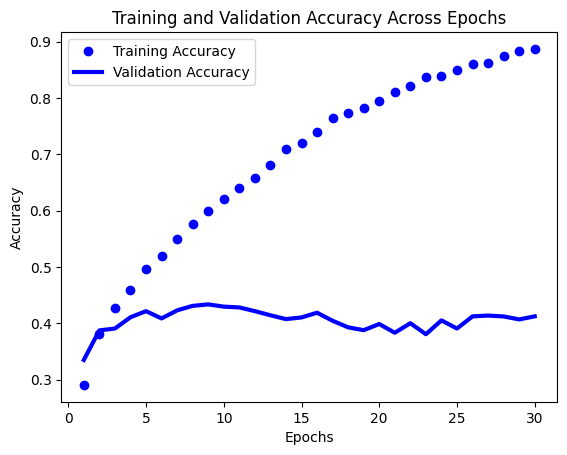

In [21]:
plot_accuracy(wider_model_history)

In [27]:
# Calculate the test accuracy
### YOUR CODE HERE ###
print(f'Test accuracy: {wider_model.evaluate(test_faces, test_emotions)[1]}')

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4086 - loss: 5.4362
Test accuracy: 0.4119531810283661


Compare the accuracy curve of `wider_model` to that of `model` from Problem 1. Which shows more evidence of overfitting after 30 epochs? Does that make sense?

<font color='red'> **Your Answer.** </font>

The wider model shows more evidence of overfitting as the accuracy curve flattens out at about the 10th epoch, while the accuracy curve of the first model can still be seen growing at the 30th epoch.

This makes sense because the wider model has more than twice as many parameters and is therefore more prone to overfitting.


## Part (d): Deeper Model [5 Points]
Now, build a new model called `deep_model` by taking `model` from Problem 1 and add an additional dense layer of 256 nodes immediately after the original dense layer of 256 nodes. The new model should have a total of 2 dense layers of 256 nodes each and have a total of 172,535 parameters.

Train the model, plot its accuracy vs epochs using the `plot_accuracy` function, and report the model's accuracy on the test set.

In [28]:
input = keras.Input(shape=train_faces.shape[1:])

### YOUR CODE BELOW ###

x = keras.layers.Rescaling(1)(input)

x = keras.layers.Conv2D(16, kernel_size=(2,2), activation='relu', name='Conv_1')(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(16, kernel_size=(2,2), activation='relu', name='Conv_2')(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(16, kernel_size=(2,2), activation='relu', name='Conv_3')(x)
x = keras.layers.MaxPool2D()(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dense(256, activation='relu')(x)

output = keras.layers.Dense(7, activation='softmax')(x)

### YOUR CODE ABOVE ###

deeper_model = keras.Model(input, output, name='deeper_cnn')
deeper_model.summary()

Model: "deeper_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_1 (Conv2D)                 │ (None, 47, 47, 16)     │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (Conv2D)                 │ (None, 22, 22, 16)     │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 11, 11, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_3 (Conv2D)                 │ (None, 10, 10, 16)     │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       102,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 172,535 (673.96 KB)

 Trainable params: 172,535 (673.96 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
deeper_model.compile(
    ### YOUR CODE HERE ###
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

deeper_model_history = deeper_model.fit(
    ### YOUR CODE HERE ###
    train_faces,
    train_emotions,
    validation_split=0.2,
    epochs=30,
    batch_size=64
)

Epoch 1/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.2366 - loss: 5.0987 - val_accuracy: 0.3231 - val_loss: 1.7147
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3443 - loss: 1.6696 - val_accuracy: 0.3602 - val_loss: 1.6550
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3907 - loss: 1.5830 - val_accuracy: 0.3678 - val_loss: 1.6171
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4270 - loss: 1.4918 - val_accuracy: 0.3741 - val_loss: 1.6138
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4600 - loss: 1.4207 - val_accuracy: 0.3811 - val_loss: 1.6161
Epoch 6/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5021 - loss: 1.3322 - val_accuracy: 0.3905 - val_loss: 1.6428
Epoch 7/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5325 - loss: 1.2451 - val_accuracy: 0.3762 - val_loss: 1.7255
Epoch 8/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5553 - loss: 1.1825 - val_accuracy: 0

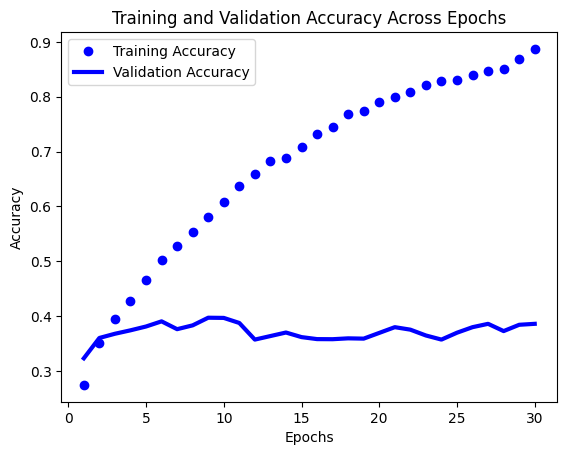

In [31]:
plot_accuracy(deeper_model_history)

In [32]:
# Calculate the test accuracy
### YOUR CODE HERE ###
print(f'Test accuracy: {deeper_model.evaluate(test_faces, test_emotions)[1]}')

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3809 - loss: 4.2321
Test accuracy: 0.3835330307483673


## Part (e): Comparison [10 points]
Comment on the difference between the test accuracy of `model`, `wider_model` and `deeper_model`. Did widening the model or deepening the model result in a better performance? Why? Do you think
this result generally holds true for all problems?

<font color='red'>**Your Answer**</font>

Test Accuracy Comparison:
* `model`: 36.75%
* `wider_model`: 41.20%
* `deeper_model`: 38.35%

Widening the model resulted in better performance. I think this result can be connected with the fact that the model learns all the actual features of the image in the convolutional layers, so increasing their complexity lets it capture more detail, which is important because emotions are something difficult to pinpoint by simple features like horizontal or vertical lines. I think that this result depends on the data you're working with and it's hard to say what works the best in general. Perhaps it could be said that complex classification tasks (classifying emotions) requires more complexity in the convolutional layers, while trivial tasks (classifying shapes) needs less complexity in the convolutional layers.

# Problem 3: Data Augmentation [15 Points]

The basic idea of augmentation is to alter the image so slightly that the value of the dependent variable (i.e. the category that it belongs to) doesn't change.

Keras allows us to easily perform data augmentation using layers such as:

* `keras.layers.RandomFlip`
* `keras.layers.RandomZoom`
* `keras.layers.RandomRotation`

Lets quickly visualize what the augmentation does ... Here, we flip the images horizontally, then apply a random zoom of up to 20%. Note that you do not need to understand how the code below works. Most of it is there to allow us to visualize the augmentation.

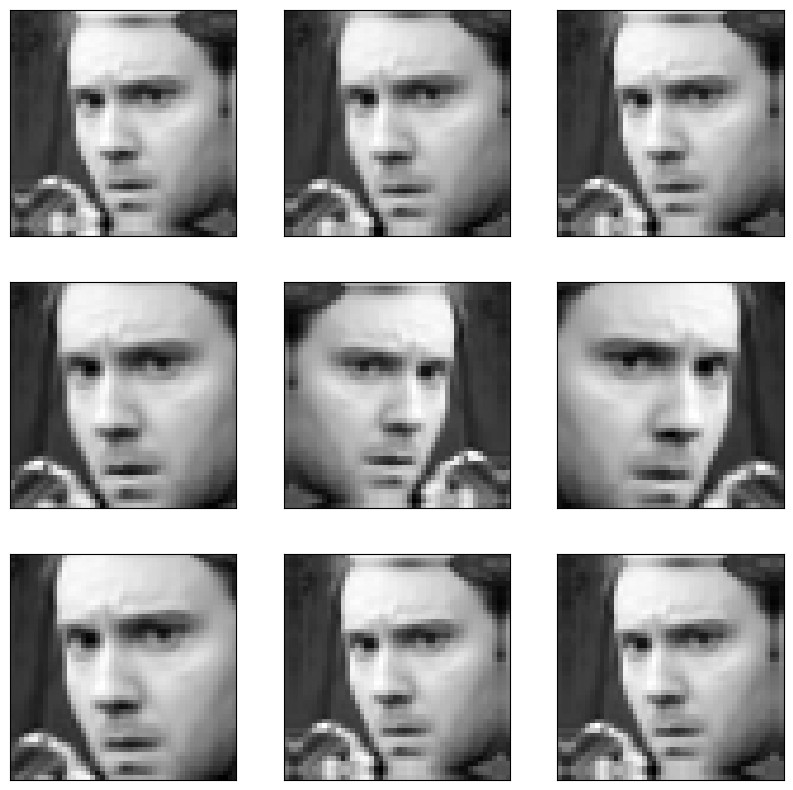

In [33]:
def augment_images(image):
    x = keras.layers.RandomFlip("horizontal")(image)
    x = keras.layers.RandomZoom(0.2)(x)
    return x

augmented_images = [augment_images(np.expand_dims(train_faces[0],axis=0)) for i in range(9)]
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1, xticks=[], yticks=[])
    ax.imshow(tf.keras.preprocessing.image.array_to_img(augmented_images[i][0]), cmap='gray', vmin=0, vmax=255)

We take our model `wider_model` from Problem 2(c) and add a random flip and random zoom as **layers** before the rescaling layer.

In [36]:
input = keras.Input(shape=(48, 48, 3))

### DATA AUGMENTATION ###
x = keras.layers.RandomFlip("horizontal")(input)
x = keras.layers.RandomZoom(0.2)(x)

### YOUR CODE HERE ###
x = keras.layers.Rescaling(1)(input)

x = keras.layers.Conv2D(32, kernel_size=(2,2), activation='relu', name='Conv_1')(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(32, kernel_size=(2,2), activation='relu', name='Conv_2')(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(32, kernel_size=(2,2), activation='relu', name='Conv_3')(x)
x = keras.layers.MaxPool2D()(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)

output = keras.layers.Dense(7, activation='softmax')(x)

model_augmented = keras.Model(input, output, name='augmented_CNN_model')
model_augmented.summary()

Model: "augmented_CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_1 (Conv2D)                 │ (None, 47, 47, 32)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (Conv2D)                 │ (None, 22, 22, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_3 (Conv2D)                 │ (None, 10, 10, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       205,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 215,527 (841.90 KB)

 Trainable params: 215,527 (841.90 KB)

 Non-trainable params: 0 (0.00 B)

Train the model (using the same parameters as all previous questions), show the accuracy vs. epoch curve, and report the accuracy on the test set.

In [37]:
model_augmented.compile(
    ### YOUR CODE HERE ###
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_augmented_history = model_augmented.fit(
    ### YOUR CODE HERE ###
    train_faces,
    train_emotions,
    validation_split=0.2,
    epochs=30,
    batch_size=64
)

Epoch 1/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.2392 - loss: 4.8776 - val_accuracy: 0.3525 - val_loss: 1.6647
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3652 - loss: 1.6286 - val_accuracy: 0.3805 - val_loss: 1.6009
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4118 - loss: 1.5290 - val_accuracy: 0.3863 - val_loss: 1.6014
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4361 - loss: 1.4735 - val_accuracy: 0.4260 - val_loss: 1.5366
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4739 - loss: 1.3821 - val_accuracy: 0.4098 - val_loss: 1.5575
Epoch 6/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5090 - loss: 1.3010 - val_accuracy: 0.4223 - val_loss: 1.5940
Epoch 7/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5393 - loss: 1.2209 - val_accuracy: 0.4124 - val_loss: 1.7244
Epoch 8/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5761 - loss: 1.1324 - val_accuracy: 

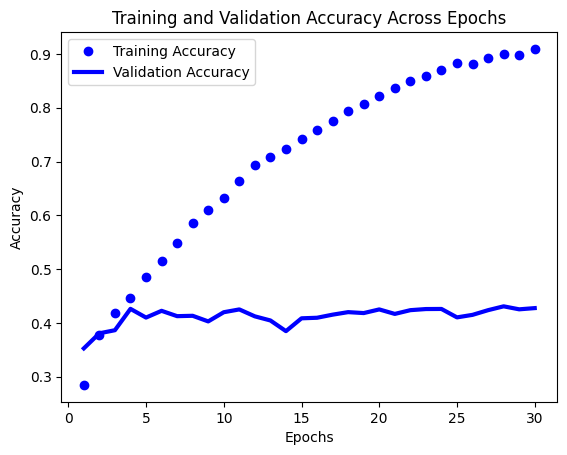

In [38]:
plot_accuracy(model_augmented_history)

In [39]:
# Calculate the test accuracy
### YOUR CODE HERE ###
print(f'Test accuracy: {model_augmented.evaluate(test_faces, test_emotions)}')

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4254 - loss: 4.8674
Test accuracy: [4.90816593170166, 0.42755642533302307]


Compare this with `wider_model` and comment on the impact of data augmentation.

* Did data augmentation reduce overfitting?
* Did data augmentation improve test set accuracy

<font color='red'> **Your Answer.** </font>

Data augmentation didn't reduce overfitting but it improved test set accuracy by about 1.5%.

# Problem 4: Transfer Learning and Fine-Tuning [25 points]

Next, we apply transfer learning to our problem using VGG19, a pre-trained model similar to ResNet50 from class. We will take VGG19 and make it "headless", then run it through our own "little" NN.

We will take three different approaches to this:

1. Part (a): **Base Transfer Learning**. Fix the weights from headless VGG19 and learn the weights on the little NN.
2. Part (b): **Some fine-tuning** Fix the weights on the top 6 out of 19 layers of VGG19, but allow the weights from the remaining 13 layers to be optimized by SGD/Adam, in addition to those of the little NN.
3. Part (c): **Fine-Tuning** Allow all weights in VGG19 to be tuned, in addition to the little NN.

For each of the models, we will plot their train/validation accuracy curve, compute their test accuracy, and compute a confusion matrix.

## Part (a): No Fine Tuning [5 Points]

Let us fetch the VGG19 model, making sure to set `include_top=False` so that we do not take its output layer. We also set `trainable=False` to indicate that the parameters in these 19 layers are not trainable.



In [40]:
base_model = keras.applications.VGG19(
    include_top=False,   # this makes VGG19 headless
    weights="imagenet",
    input_tensor=None,
    input_shape=(48, 48, 3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

# Freeze the base_model so that it is not trainable at all
base_model.trainable = False

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


We build a neural network that performs data augmentation and rescaling, then uses the VGG19, and finally has one dense layer before the output layer.

In [44]:
inputs = keras.Input(shape=(48,48,3))

x = keras.layers.RandomFlip("horizontal")(inputs)
x = keras.layers.RandomZoom(0.2)(x)
x = keras.layers.Rescaling(1./255)(x) # normalizing

# Add layers from base_model one at a time
x = base_model(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(7, activation='softmax')(x)

transfer_model = keras.Model(inputs, outputs, name='transfer_model')
transfer_model.summary()

Model: "transfer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_15 (RandomFlip)     │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_15 (RandomZoom)     │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 1, 1, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,157,511 (76.89 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Train the model. Here, we use a learning rate of 0.00002 to get better convergence.

In [45]:
transfer_model.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adam(2e-5),
            metrics=['accuracy'])

transfer_model_history = transfer_model.fit(train_faces, train_emotions, epochs=30, validation_split=0.2)

Epoch 1/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.2028 - loss: 1.8833 - val_accuracy: 0.2882 - val_loss: 1.7437
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.2909 - loss: 1.7506 - val_accuracy: 0.3220 - val_loss: 1.6956
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.3148 - loss: 1.7117 - val_accuracy: 0.3316 - val_loss: 1.6713
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.3261 - loss: 1.6915 - val_accuracy: 0.3384 - val_loss: 1.6568
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.3278 - loss: 1.6779 - val_accuracy: 0.3420 - val_loss: 1.6454
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.3371 - loss: 1.6707 - val_accuracy: 0.3464 - val_loss: 1.6372
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.3423 - loss: 1.6629 - val_accuracy: 0.3518 - val_loss: 1.6298
Epoch 8/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.3481 - loss: 1.6526 - 

We can plot the training and validation accuracy curve.

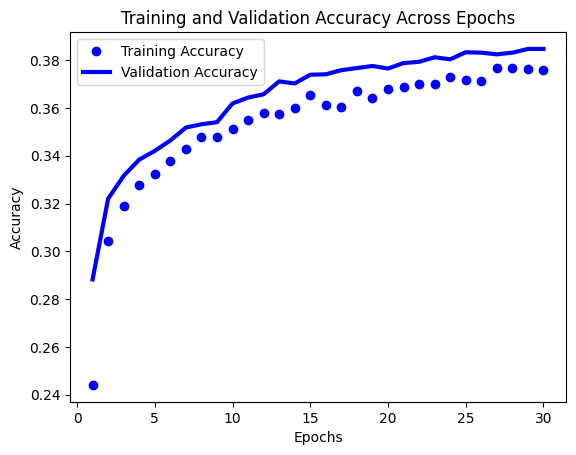

In [46]:
plot_accuracy(transfer_model_history)

Let's also calculate the confusion matrix and the accuracy on the test set.

The function `show_confusion_matrix` has been written for you below. You can apply it to any Keras Model and it will calculate:
* Test accuracy
* A confusion matrix. Recall that each row of the confusion matrix are the actual labels and each column are the predictions. For example, if element in row `happy` and column `sad` is 250, then there are 250 data points in the test set where the true label is `happy` but we predicted `sad`.
* A heatmap of the confusion matrix, where each row is normalized to add up to 1.0. For example, if element in row `happy` and column `sad` is 0.25, then that means 25% of data points with a true label of `happy` were predicted as `sad`.

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
*************************
* Test Accuracy: 0.3760 *
*************************


,angry,disgust,fear,happy,sad,surprise,neutral
angry,121,0,53,456,113,61,154
disgust,12,0,13,49,16,7,14
fear,50,0,127,383,149,156,159
happy,55,0,50,1353,108,47,161
sad,92,0,94,544,301,31,185
surprise,33,0,65,204,28,408,93
neutral,74,0,43,566,109,52,389


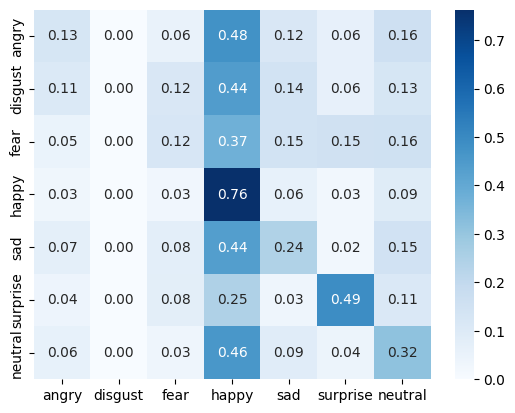

In [47]:
from IPython.display import display

def show_confusion_matrix(model):
    """
    Calculates the test accuracy, confusion matrix and heat map for a model.
    """
    global test_faces, test_emotions, emotions_names

    y_pred = model.predict(test_faces).argmax(axis=1)
    y_actual = test_emotions.argmax(axis=1)

    print('*************************\n* Test Accuracy: %.4f *\n*************************' % metrics.accuracy_score(y_actual, y_pred))

    cm = pd.DataFrame(metrics.confusion_matrix(y_actual, y_pred), index=emotions_names, columns=emotions_names)
    display(cm)

    cm = cm.div(cm.sum(axis=1), axis=0)

    sns.heatmap(cm, cmap="Blues", annot=True, fmt=".2f")

show_confusion_matrix(transfer_model)

Please comment briefly on the model's performance.

<font color='red'> **Your Answer** </font>

The model performs worse than the simple wider or the deeper models.

## Part (b): Some Fine Tuning [5 Points]
In this part, we will allow our optimization model to tune **some** of the layers from VGG19. In particular, we will only freeze the first 15 layers and allow the remaining layers to be trained.


In [53]:
base_model = keras.applications.VGG19(
    include_top=False,   # this makes VGG19 headless
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

inputs = keras.Input(shape=(48,48,3))

x = keras.layers.RandomFlip("horizontal")(inputs)
x = keras.layers.RandomZoom(0.2)(x)
x = keras.layers.Rescaling(1./255)(x) # normalizing

# Add layers from base_model
for layer in base_model.layers:
    # Skip layers that don't support being called directly
    try:
        x = layer(x)
    except TypeError:
        continue

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(7, activation='softmax')(x)

partial_model = keras.Model(inputs, outputs, name='partial_fine_tune_model')

# Make the first 15 layers not trainable. All other layers are trainable
for layer in partial_model.layers[:15]:
    layer.trainable = False

partial_model.summary()

Model: "partial_fine_tune_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_18 (RandomFlip)     │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_18 (RandomZoom)     │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_10 (Rescaling)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             

 Total params: 20,157,511 (76.89 MB)

 Trainable params: 17,831,943 (68.02 MB)

 Non-trainable params: 2,325,568 (8.87 MB)

Let's see which layers are trainable. Notice that VGG19 consists of 4 blocks of convolution filters (block1_conv1, block1_conv2, ..., block5_conv4). We are allowing block4 and block5 to be trained and freezing blocks 1, 2 and 3.

In [54]:
for i, layer in enumerate(partial_model.layers):
    print('Layer %d: %s (%s), Trainable=%s' % (i+1, layer.name, layer.__class__.__name__, layer.trainable))

Layer 1: input_layer_15 (InputLayer), Trainable=False
Layer 2: random_flip_18 (RandomFlip), Trainable=False
Layer 3: random_zoom_18 (RandomZoom), Trainable=False
Layer 4: rescaling_10 (Rescaling), Trainable=False
Layer 5: block1_conv1 (Conv2D), Trainable=False
Layer 6: block1_conv2 (Conv2D), Trainable=False
Layer 7: block1_pool (MaxPooling2D), Trainable=False
Layer 8: block2_conv1 (Conv2D), Trainable=False
Layer 9: block2_conv2 (Conv2D), Trainable=False
Layer 10: block2_pool (MaxPooling2D), Trainable=False
Layer 11: block3_conv1 (Conv2D), Trainable=False
Layer 12: block3_conv2 (Conv2D), Trainable=False
Layer 13: block3_conv3 (Conv2D), Trainable=False
Layer 14: block3_conv4 (Conv2D), Trainable=False
Layer 15: block3_pool (MaxPooling2D), Trainable=False
Layer 16: block4_conv1 (Conv2D), Trainable=True
Layer 17: block4_conv2 (Conv2D), Trainable=True
Layer 18: block4_conv3 (Conv2D), Trainable=True
Layer 19: block4_conv4 (Conv2D), Trainable=True
Layer 20: block4_pool (MaxPooling2D), Trainabl

Train the model and examine its train/validation curve, test accuracy and confusion matrix.

In [ ]:
partial_model.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adam(2e-5),
            metrics=['accuracy'])

partial_model_history = partial_model.fit(train_faces, train_emotions, epochs=30, validation_split=0.2)

Epoch 1/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 44s 57ms/step - accuracy: 0.3597 - loss: 1.6194 - val_accuracy: 0.4831 - val_loss: 1.3501
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 0.4824 - loss: 1.3450 - val_accuracy: 0.5193 - val_loss: 1.2556
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 0.5260 - loss: 1.2426 - val_accuracy: 0.5331 - val_loss: 1.2158
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 0.5528 - loss: 1.1714 - val_accuracy: 0.5578 - val_loss: 1.1752
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - accuracy: 0.5803 - loss: 1.1079 - val_accuracy: 0.5498 - val_loss: 1.1967
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - accuracy: 0.6080 - loss: 1.0508 - val_accuracy: 0.5690 - val_loss: 1.1453
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - accuracy: 0.6316 - loss: 0.9857 - val_accuracy: 0.5735 - val_loss: 1.1378
Epoch 8/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - accuracy: 0.6591 - loss: 0.9283 - 

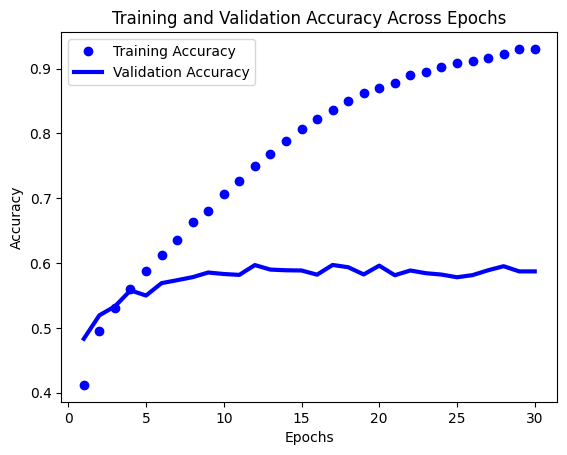

In [56]:
plot_accuracy(partial_model_history)

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
*************************
* Test Accuracy: 0.6053 *
*************************


,angry,disgust,fear,happy,sad,surprise,neutral
angry,514,1,83,62,186,20,92
disgust,33,42,3,3,22,0,8
fear,130,1,421,40,257,82,93
happy,44,0,34,1410,119,37,130
sad,159,0,104,99,705,21,159
surprise,29,0,79,37,51,601,34
neutral,100,0,67,108,286,20,652


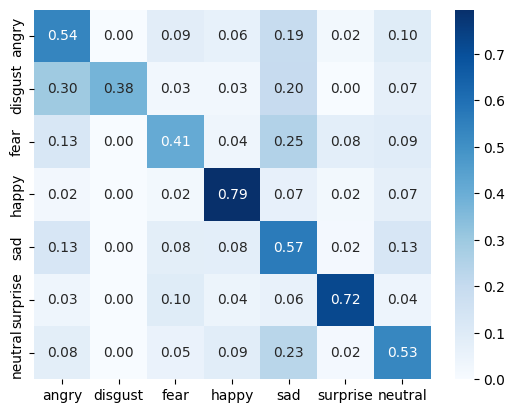

In [57]:
show_confusion_matrix(partial_model)

Please comment briefly on the model's performance.  

<font color='red'> **Your Answer** </font>

The model performs way better than the untuned model using VGG19 and the wider model. The jump in performance is bigger that between any of the other models: 60.53 - 41.20 = 19.33%.

## Part (c): Fine Tuning [5 Points]
Now, let's try a transfer learning model where all layers can be fine tuned.

In [58]:
base_model = keras.applications.VGG19(
    include_top=False,   # this makes VGG19 headless
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

inputs = keras.Input(shape=(48,48,3))

x = keras.layers.RandomFlip("horizontal")(inputs)
x = keras.layers.RandomZoom(0.2)(x)
x = keras.layers.Rescaling(1./255)(x) # normalizing

# Add layers from base_model
for layer in base_model.layers:
    # Skip layers that don't support being called directly
    try:
        x = layer(x)
    except TypeError:
        continue

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(7, activation='softmax')(x)

tuned_model = keras.Model(inputs, outputs, name='full_fine_tune_model')

# Let's see which layers are trainable
for i, layer in enumerate(tuned_model.layers):
    print('Layer %d: %s (%s), Trainable=%s' % (i+1, layer.name, layer.__class__.__name__, layer.trainable))

Layer 1: input_layer_17 (InputLayer), Trainable=True
Layer 2: random_flip_19 (RandomFlip), Trainable=True
Layer 3: random_zoom_19 (RandomZoom), Trainable=True
Layer 4: rescaling_11 (Rescaling), Trainable=True
Layer 5: block1_conv1 (Conv2D), Trainable=True
Layer 6: block1_conv2 (Conv2D), Trainable=True
Layer 7: block1_pool (MaxPooling2D), Trainable=True
Layer 8: block2_conv1 (Conv2D), Trainable=True
Layer 9: block2_conv2 (Conv2D), Trainable=True
Layer 10: block2_pool (MaxPooling2D), Trainable=True
Layer 11: block3_conv1 (Conv2D), Trainable=True
Layer 12: block3_conv2 (Conv2D), Trainable=True
Layer 13: block3_conv3 (Conv2D), Trainable=True
Layer 14: block3_conv4 (Conv2D), Trainable=True
Layer 15: block3_pool (MaxPooling2D), Trainable=True
Layer 16: block4_conv1 (Conv2D), Trainable=True
Layer 17: block4_conv2 (Conv2D), Trainable=True
Layer 18: block4_conv3 (Conv2D), Trainable=True
Layer 19: block4_conv4 (Conv2D), Trainable=True
Layer 20: block4_pool (MaxPooling2D), Trainable=True
Layer 21

In [60]:
tuned_model.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adam(2e-5),
            metrics=['accuracy'])

tuned_model_history = tuned_model.fit(train_faces, train_emotions, epochs=30, validation_split=0.2)

Epoch 1/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step - accuracy: 0.5196 - loss: 1.2603 - val_accuracy: 0.5373 - val_loss: 1.2082
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 48s 66ms/step - accuracy: 0.5606 - loss: 1.1512 - val_accuracy: 0.5610 - val_loss: 1.1654
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 48s 67ms/step - accuracy: 0.5951 - loss: 1.0713 - val_accuracy: 0.5773 - val_loss: 1.1452
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 48s 67ms/step - accuracy: 0.6183 - loss: 1.0124 - val_accuracy: 0.5888 - val_loss: 1.1008
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 48s 67ms/step - accuracy: 0.6500 - loss: 0.9417 - val_accuracy: 0.5989 - val_loss: 1.0868
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 48s 67ms/step - accuracy: 0.6723 - loss: 0.8818 - val_accuracy: 0.5996 - val_loss: 1.0974
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 48s 67ms/step - accuracy: 0.6933 - loss: 0.8282 - val_accuracy: 0.6017 - val_loss: 1.0995
Epoch 8/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 48s 67ms/step - accuracy: 0.7189 - loss: 0.7695 - 

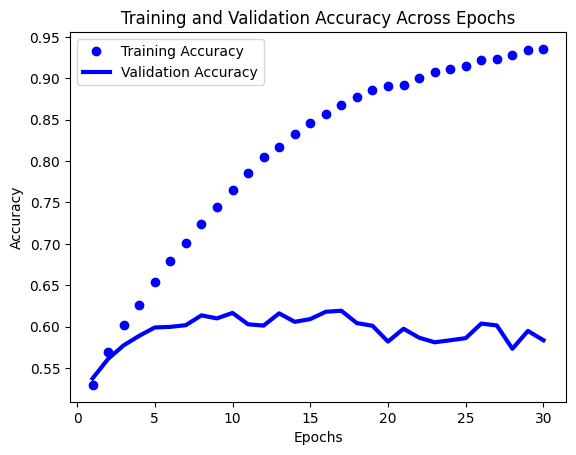

In [61]:
plot_accuracy(tuned_model_history)

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
*************************
* Test Accuracy: 0.5910 *
*************************


,angry,disgust,fear,happy,sad,surprise,neutral
angry,573,5,198,46,83,14,39
disgust,42,35,20,4,5,3,2
fear,175,0,539,33,143,77,57
happy,66,0,71,1480,40,61,56
sad,301,1,245,71,471,22,136
surprise,32,0,115,40,26,607,11
neutral,211,1,160,121,179,24,537


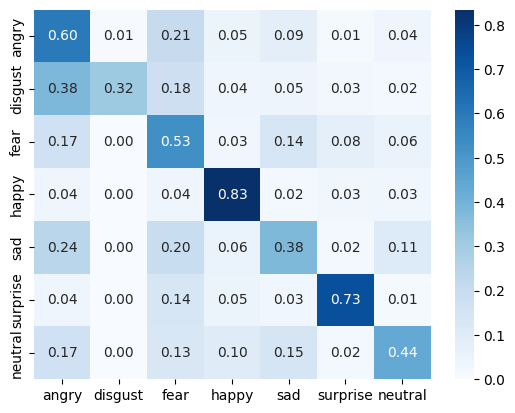

In [62]:
show_confusion_matrix(tuned_model)

Please comment briefly on the model's performance.  

<font color='red'> **Your Answer** </font>

The model has better accuracy than the partly tuned model at the 10th epoch but it overfits the data after and performance starts to decline

## Part (d): Comparison [10 Points]

Please fill in the table below with the test accuracies of the three models above, as well as that of `wider_model` from Problem 2.

<font color='red'>**Your Answer.**</font>

Model Test Accuracy:
* Model (a) with no fine tuning: 37.60%
* Model (b) with some fine tuning: 60.53%
* Model (c) with fine tuning: 59.10%
* `wider_model` from Problem 2(a)-(c): 41.20%


Comment on the performance of Models (a), (b) and (c). In particular, please address the following questions:

* Why do models (b) and (c) perform so much better than `wider_model`?
* Why do you think Model (a) performs so poorly?
* Why do you think Model (c) performs better than model (b)?

<font color='red'>**Your Answer.**</font>

The models (b) and (c) perform better than the wider model because they utlize the base model, which was trained on much richer data with many of the images potentially also being images of people's faces. They are then further trained on this data and their weights from the base model are optimised with the particular goal of classifying emotions.

Model (a) performs poorly because the weights taken from the base model are unchanged, and the base model was trained on many other images and not for this particular task, so its convolutional layers didn't learn to pick up exactly those features which are helpful in classifying human emotions.

Model (c) performs better for the obvious reason of being fully fine-tuned for this specific problem, so the weights of its earlier layers are also changed to be optimised for this task.